In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import calibration
import sklearn.linear_model
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
import numpy as np
import scipy.stats
from sklearn.base import clone
from sklearn.model_selection._search import ParameterSampler
from sklearn.metrics import brier_score_loss, make_scorer, log_loss, mean_squared_error
os.chdir('/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability')
from src.generate_data import get_game_data, get_division_data, get_odds_data, get_schedule_data
import statsmodels.api as sm

In [13]:
df = pd.read_csv("data/yards_gained_all_seasons.csv")
game_data = get_game_data(cache=True)
game_data = game_data.drop_duplicates("game_code")
division_data = get_division_data(cache=True)
combined_df = df.merge(game_data, on=["game_code", "season"], how="left", copy=False)

Running get_game_data... 

get_game_data is returning cached df
get_game_data done in 0 sec.
Running get_division_data... 

get_division_data is returning cached df
get_division_data done in 0 sec.


In [14]:
def get_rolling_value(df, freq=16, min_periods=16, shift=1):
    cols = ["total_expected_yards_gained", "total_yards_gained", "total_yards_added", "play_count"]
    df2 = df.rolling(freq, on="game_date", min_periods=min_periods)[cols].mean().shift(shift)
    df4 = pd.concat([df[["game_code", "season", "game_date", "offense_team", "defense_team", "home_team_id", "vis_team_id"]],
                     df2[["total_expected_yards_gained", "total_yards_gained", "total_yards_added", "play_count"]]], axis=1)
    return df4


In [15]:
aggregate_values = ["total_expected_yards_gained", "total_yards_gained", "total_yards_added", "play_count"]
group_values = ["game_code", "season", "game_date", "offense_team", "defense_team", "home_team_id", "vis_team_id"]
game_yards = combined_df[group_values + aggregate_values].groupby(group_values, as_index=False).sum()

In [16]:
rolling_offense = game_yards.sort_values("game_date").groupby("offense_team", as_index=False).apply(get_rolling_value)

In [17]:
rolling_defense = game_yards.sort_values("game_date").groupby("defense_team", as_index=False).apply(get_rolling_value)

In [18]:
game_codes = combined_df[["game_code", "home_team_id", "vis_team_id", "home_team_abbrev", "vis_team_abbrev", "home_score", "vis_score", "game_date", "season"]].drop_duplicates()

In [19]:
game_codes.columns

Index(['game_code', 'home_team_id', 'vis_team_id', 'home_team_abbrev',
       'vis_team_abbrev', 'home_score', 'vis_score', 'game_date', 'season'],
      dtype='object')

In [20]:
rolling_offense.columns

Index(['game_code', 'season', 'game_date', 'offense_team', 'defense_team',
       'home_team_id', 'vis_team_id', 'total_expected_yards_gained',
       'total_yards_gained', 'total_yards_added', 'play_count'],
      dtype='object')

In [21]:
yards_values = ['total_expected_yards_gained', 'total_yards_gained', 'total_yards_added', 'play_count']
games_home_team = game_codes.merge(rolling_offense[["game_code", "offense_team"] + yards_values], left_on=["game_code", "home_team_id"], right_on=["game_code", "offense_team"], suffixes=["", "_offense"])
games_home_team = games_home_team.merge(rolling_defense[["game_code", "defense_team"] + yards_values], left_on=["game_code", "home_team_id"], right_on=["game_code", "defense_team"], suffixes=["_offense", "_defense"])


In [22]:
yards_values = ['total_expected_yards_gained', 'total_yards_gained', 'total_yards_added', 'play_count']
games_vis_team = game_codes.merge(rolling_offense[["game_code", "offense_team"] + yards_values], left_on=["game_code", "vis_team_id"], right_on=["game_code", "offense_team"], suffixes=["", "_offense"])
games_vis_team = games_vis_team.merge(rolling_defense[["game_code", "defense_team"] + yards_values], left_on=["game_code", "vis_team_id"], right_on=["game_code", "defense_team"], suffixes=["_offense", "_defense"])

In [23]:
games = games_home_team.merge(games_vis_team, on=['game_code', 'season', 'home_team_id', 'vis_team_id', 'home_team_abbrev', 'vis_team_abbrev', 'home_score', 'vis_score', 'game_date'], suffixes=["_home", "_away"])
games = games[games["season"]>=2016]


In [24]:
features = ["total_yards_added_offense_home",
            "total_yards_added_defense_home",
            "total_yards_added_offense_away",
            "total_yards_added_defense_away",]
target = ["home_score","vis_score"]

In [25]:
ridge_model_home = sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0))
ridge_model_home.fit(games[features], games["home_score"])
ridge_model_home.score(games[features], games["home_score"])
games["x_home_score"] = ridge_model_home.predict(games[features])

In [26]:
ridge_model_vis = sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0))
ridge_model_vis.fit(games[features], games["vis_score"])
ridge_model_vis.score(games[features], games["vis_score"])
games["x_vis_score"] = ridge_model_vis.predict(games[features])

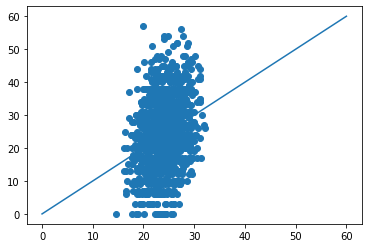

In [27]:
plt.scatter(games["x_home_score"], games["home_score"])
plt.plot([0,60], [0,60])

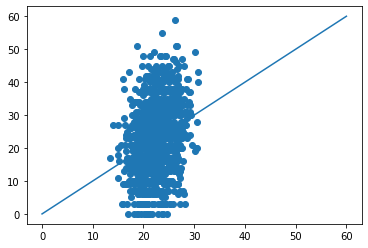

In [28]:
plt.scatter(games["x_vis_score"], games["vis_score"])
plt.plot([0,60], [0,60])

In [29]:

X2 = sm.add_constant(games[features])
est = sm.OLS(games["home_score"], X2)
results_new = []
results_fu = est.fit()
for x in np.arange(0.005, 0.25, 0.005).tolist():
    est2 = est.fit_regularized(L1_wt=0, alpha=x)
    results_fr_fit = sm.regression.linear_model.OLSResults(est, 
                                                            est2.params, 
                                                            results_fu.normalized_cov_params)

    results_new.append(results_fr_fit.ssr)
    # print(est2.model.score(est2.params))


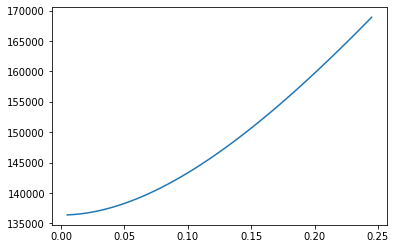

In [30]:
plt.plot(np.arange(0.005, 0.25, 0.005).tolist(), results_new)

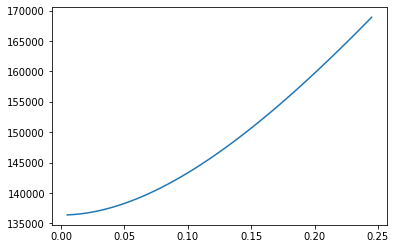

In [31]:
plt.plot(np.arange(0.005, 0.25, 0.005).tolist(), results_new)

In [32]:
results_fr = est.fit_regularized(L1_wt=0, alpha=0.1, start_params=results_fu.params)
final = sm.regression.linear_model.OLSResults(est, 
                                              results_fr.params, 
                                              est.normalized_cov_params)

print(final.summary())


                            OLS Regression Results                            
Dep. Variable:             home_score   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     13.61
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           6.79e-11
Time:                        13:28:03   Log-Likelihood:                -5461.6
No. Observations:                1473   AIC:                         1.093e+04
Df Residuals:                    1468   BIC:                         1.096e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [33]:
games.to_clipboard()

In [34]:
est2.summary()

NotImplementedError: 

In [ ]:
games["total_yards_added_offense_home_per_play"] = games["total_yards_added_offense_home"] / games["play_count_offense_home"] 
games["total_yards_added_defense_home_per_play"] = games["total_yards_added_defense_home"] / games["play_count_defense_home"] 
games["total_yards_added_offense_away_per_play"] = games["total_yards_added_offense_away"] / games["play_count_offense_away"] 
games["total_yards_added_defense_away_per_play"] = games["total_yards_added_defense_away"] / games["play_count_defense_away"] 


In [ ]:
games.columns

In [ ]:

new_features = [
    'total_yards_added_offense_home_per_play',
    'total_yards_added_defense_home_per_play',
    'total_yards_added_offense_away_per_play',
    'total_yards_added_defense_away_per_play',
    'play_count_offense_home',
    'play_count_defense_home',
    'play_count_offense_away', 
    'play_count_defense_away'

       ]
X2 = sm.add_constant(games[new_features])
est = sm.OLS(games["vis_score"], X2)
est2 = est.fit()
print(est2.summary())


In [ ]:

new_features = [
    'total_yards_added_offense_home_per_play',
    'total_yards_added_defense_home_per_play',
    'total_yards_added_offense_away_per_play',
    'total_yards_added_defense_away_per_play',
    'play_count_offense_home',
    'play_count_defense_home',
    'play_count_offense_away', 
    'play_count_defense_away'

       ]
X2 = sm.add_constant(games[new_features])
est = sm.OLS(games["home_score"], X2)
est2 = est.fit()
print(est2.summary())


In [ ]:
X2 = sm.add_constant(games[features])
est = sm.OLS(games["vis_score"], X2)
est2 = est.fit()
print(est2.summary())


In [ ]:
X2 = sm.add_constant(games[features])
est = sm.OLS(games["home_score"], X2)
est2 = est.fit()
print(est2.summary())


In [ ]:
games["home_team_win"] = np.where(games["home_score"] > games["vis_score"], 1, 0)
games["away_team_win"] = np.where(games["home_score"] < games["vis_score"], 1, 0)
games["tie"] = np.where(games["home_score"] == games["vis_score"], 1, 0)

In [ ]:
X2 = sm.add_constant(games[features])
est = sm.OLS(games["vis_score"], X2)
est2 = est.fit()
print(est2.summary())


In [ ]:
X2 = sm.add_constant(games[features])
est = sm.Logit(games["home_team_win"], X2)
est2 = est.fit()
games["x_home_team_win"] = est2.predict(X2)
print(est2.summary())


In [ ]:
X2 = sm.add_constant(games[features])
est = sm.Logit(games["away_team_win"], X2)
est2 = est.fit()
games["x_away_team_win"] = est2.predict(X2)
games["x_tie_calculated"] = 1 - games["x_away_team_win"] - games["x_home_team_win"]
print(est2.summary())


In [ ]:
X2 = sm.add_constant(games[features])
est = sm.Logit(games["tie"], X2)
est2 = est.fit()
games["x_tie"] = est2.predict(X2)

print(est2.summary())


In [ ]:
games["x_total_score"] = games["x_home_score"] + games["x_vis_score"]
games["x_line"] = games["x_vis_score"]- games["x_home_score"]

view = games[["season", "game_date", "home_team_abbrev", "vis_team_abbrev", "x_total_score", "x_line", "x_home_team_win", "x_away_team_win", "x_tie", "x_tie_calculated"] + features + target + ["x_home_score", "x_vis_score"]]

In [ ]:
view.to_clipboard()

In [ ]:
plt.hist(games["x_home_score"])

In [ ]:
lower, higher = 0, 100
plt.hist(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
plt.xlim([0,60])
np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
print(np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"]), np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["x_home_score"]))
np.std(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])


In [ ]:
lower, higher = 0, 20
plt.hist(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
plt.xlim([0,60])
np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
print(np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"]), np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["x_home_score"]))
np.std(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])


In [ ]:
lower, higher = 20, 22.5
plt.hist(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
plt.xlim([0,60])
np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
print(np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"]), np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["x_home_score"]))
np.std(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])


In [ ]:
lower, higher = 22.5, 25
plt.hist(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
plt.xlim([0,60])
np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
print(np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"]), np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["x_home_score"]))

np.std(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])

In [ ]:
lower, higher = 25, 27.5
plt.hist(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
plt.xlim([0,60])
np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
print(np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"]), np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["x_home_score"]))
np.std(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])


In [ ]:
lower, higher = 27.5, 100
plt.hist(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
plt.xlim([0,60])
np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])
print(np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"]), np.mean(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["x_home_score"]))
np.std(games[(games["x_home_score"]>lower)&(games["x_home_score"]<higher)]["home_score"])

In [ ]:
plt.scatter(games["x_home_team_win"], games["x_tie"])

In [ ]:
games["line"] = games["vis_score"] - games["home_score"]

In [ ]:
plt.hist(games["x_line"])


In [ ]:

lower, higher = -50,50
plt.hist(games[(games["x_line"]>lower)&(games["line"]<higher)]["line"])
plt.xlim([-50,50])
np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]))
np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])


In [ ]:
lower, higher = -50,-10
plt.hist(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
plt.xlim([-50,50])
np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]))
np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])


In [ ]:
lower, higher = -50,-7.5
plt.hist(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
plt.xlim([-50,50])
np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]))
np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])


In [ ]:
lower, higher = -7.5,-5
plt.hist(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
plt.xlim([-50,50])
np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]))
np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])


In [ ]:
lower, higher = -5,-2.5
plt.hist(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
plt.xlim([-50,50])
np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]))
np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])


In [ ]:
lower, higher = -2.5,0
plt.hist(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
plt.xlim([-50,50])
np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]))
np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])


In [ ]:
lower, higher = 0,2.5
plt.hist(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
plt.xlim([-50,50])
np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]))
np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])


In [ ]:
lower, higher = 2.5,5
plt.hist(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
plt.xlim([-50,50])
np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]))
np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])


In [ ]:
lower, higher = 5, 50
plt.hist(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
plt.xlim([-50,50])
np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]))
np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])


In [ ]:
number_buckets = [(-50, -7.5), (-7.5, -5), (-5, -2.5), (-2.5, 0), (0, 2.5), (2.5, 5), (5, 50)]

for x in number_buckets:
    lower = x[0]
    higher = x[1]
    print(np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"]), np.mean(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]), len(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["x_line"]), np.std(games[(games["x_line"]>lower)&(games["x_line"]<higher)]["line"])
)

In [ ]:
games["line_abs_miss"] = abs(games["line"] - games["x_line"])
plt.scatter(abs(games["x_line"]), abs(games["line"]), alpha=.2)
# np.where(games["x_line"]>0, games["x_line"], -games["x_line"])

In [ ]:
odds = pd.read_parquet("data/odds_data.parquet")
odds = odds.drop_duplicates("game_code")

In [ ]:
games=games.merge(odds[["game_code", "cur_spread"]], on="game_code")

In [ ]:
games["line_abs_miss"] = abs(games["line"] - games["x_line"])
plt.scatter(abs(games["cur_spread"]), abs(games["line"]), alpha=.2)
# np.where(games["x_line"]>0, games["x_line"], -games["x_line"])

In [ ]:
np.std(games["line_abs_miss"])

In [ ]:
np.corrcoef(games["x_line"], games["cur_spread"])**2


In [ ]:
plt.hist(odds["cur_spread"])

In [ ]:
import itertools
import numpy as np
randomized_cycle = itertools.cycle(np.random.normal(size=250000))
randomly_simulated_value = next(randomized_cycle)
randomly_simulated_value * 9 + 25



In [ ]:
current_values = games_home_team.append(games_vis_team).sort_values("game_date", ascending=False).drop_duplicates(["offense_team"])

In [ ]:
game_data

In [ ]:
import datetime
schedule = pd.read_parquet("data/schedule_data.parquet")
schedule = schedule[schedule["game_date"]> pd.to_datetime(datetime.date.today())]

In [ ]:
current_values.columns

In [ ]:
predictions = schedule.merge(current_values[['offense_team', 'total_yards_added_offense', 'total_yards_added_defense']], left_on=["home_team_id"], right_on=["offense_team"], suffixes=["", "_home"])
predictions = predictions.merge(current_values[['offense_team', 'total_yards_added_offense', 'total_yards_added_defense']], left_on=["vis_team_id"], right_on=["offense_team"], suffixes=["_home", "_away"])

In [ ]:
predictions["x_home_score"] = ridge_model_home.predict(predictions[features])
predictions["x_vis_score"] = ridge_model_vis.predict(predictions[features])
predictions["x_line"] = predictions["x_vis_score"] - predictions["x_home_score"]

In [ ]:
import itertools
import numpy as np
score_dicts = {}
outcome_dicts = {}
import time
init_time = time.time()
for x in predictions["game_code"]:
    print(x)
    def simulate_results(pred_mean, pred_std):
        randomized_cycle = itertools.cycle(np.random.normal(size=250000))
        random_sample = next(randomized_cycle)
        score_diff = round(random_sample * pred_std + pred_mean)
        return score_diff
    score_diffs = []
    final_result = []
    for simulations in range(1):
        pred = int(simulate_results(predictions[predictions["game_code"] == x]["x_line"], 13.334230852348464))
        score_diffs.append(pred)
        final_result.append(np.where(pred<0, 'W', np.where(pred>0, 'L', 'T')))
    outcome_dicts[x] = final_result
    score_dicts[x] = score_diffs
    print(time.time() - init_time)



In [ ]:
test = pd.DataFrame(score_dicts).T

In [ ]:
test.to_clipboard()

In [ ]:
pred

In [ ]:
games[games["season"]==2021][["home_team_win", "away_team_win", "tie", "home_team_id"]].groupby("home_team_id", as_index=False).sum()

In [ ]:
home_team_record = games[games["season"]==2021][["home_team_win", "away_team_win", "tie", "home_team_id"]].groupby("home_team_id", as_index=False).sum()
away_team_record = games[games["season"]==2021][["home_team_win", "away_team_win", "tie", "vis_team_id"]].groupby("vis_team_id", as_index=False).sum()

In [ ]:
current_values.to_clipboard()

In [ ]:
plt.hist(games[games["season"]==2021]["line"])

In [ ]:
np.std((games["line"] - games["x_line"]))